# Setup

In [1]:
import importlib
import itertools
import pandas as pd

from tqdm import tqdm
from src.utils import utils
from src.utils import visualization as viz


importlib.invalidate_caches()
importlib.reload(utils)
importlib.reload(viz)

<module 'src.utils.visualization' from '/home/henri/Documents/ETS/Projects/brown-build-detection-llm/src/utils/visualization.py'>

In [2]:
# configuration
tqdm.pandas()

# global variables
config = {
    "toImageButtonOptions": {
        "format": "png",  # one of png, svg, jpeg, webp
        "filename": "noise_dist",
        "height": 400,
        "width": 500,
        "scale": 3,
    }
}

# Load data

In [3]:
input_file = "../data/veloren.pickle"

In [4]:
df = pd.read_pickle(input_file)
df.shape

(57351, 9)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57351 entries, 0 to 57350
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   id           57351 non-null  int64              
 1   name         57351 non-null  object             
 2   status       57351 non-null  category           
 3   created_at   57351 non-null  datetime64[ns, UTC]
 4   finished_at  34522 non-null  datetime64[ns, UTC]
 5   duration     33987 non-null  float32            
 6   commit       57351 non-null  object             
 7   project      57351 non-null  int32              
 8   log          1 non-null      Sparse[object, nan]
dtypes: Sparse[object, nan](1), category(1), datetime64[ns, UTC](2), float32(1), int32(1), int64(1), object(2)
memory usage: 2.8+ MB


/tmp/ipykernel_626821/3771845804.py:1: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df.info()


### Identifying Brown Jobs

In [6]:
reruns = utils.list_rerun_suites(df)
flaky_reruns = utils.list_flaky_rerun_suites(reruns)

flaky_job_ids = list(itertools.chain(*flaky_reruns["id"].to_list()))
df["brown"] = df.progress_apply(
    lambda job: (
        1 if ((job["id"] in flaky_job_ids) and (job["status"] == "failed")) else 0
    ),
    axis=1,
).astype("category")

100%|██████████| 57351/57351 [00:03<00:00, 18487.22it/s]


In [7]:
# df.to_pickle(input_file)

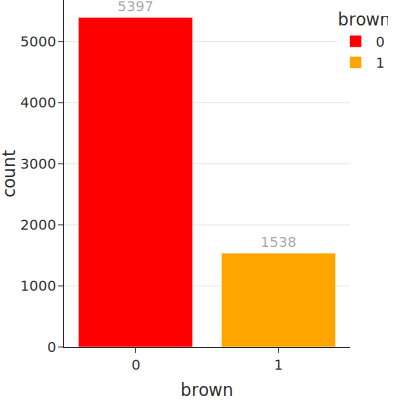

In [8]:
viz.plot_bar(df[df["status"] == "failed"], col="brown", config=config, figsize=(400, 400), font_size=14, params={
    "color": "brown",
    "color_discrete_map": {
        0: "red",
        1: 'orange'
    }
})

In [9]:
flaky_reruns.head()

,project,commit,name,id,status,created_at,finished_at
0,10174980,0052af85bcfd0846566d220642bb051b9247b8c9,translation,"[3535683030, 3535793687, 3535812277, 353581275...","[success, failed, failed, success, success]","[2022-12-29 20:09:15.111000+00:00, 2022-12-29 ...","[2022-12-29 20:14:18.768000+00:00, 2022-12-29 ..."
1,10174980,00b2bcb7b4ee4ac143d2e1d6ee55a6c2ea8b8737,benchmarks,"[4317300679, 4318026424, 4318144588, 431827735...","[success, failed, failed, success, failed, suc...","[2023-05-19 17:55:15.625000+00:00, 2023-05-19 ...","[2023-05-19 18:38:18.686000+00:00, 2023-05-19 ..."
2,10174980,00b2bcb7b4ee4ac143d2e1d6ee55a6c2ea8b8737,coverage,"[4317300680, 4317364551, 4318026429, 431808579...","[failed, success, failed, failed, failed, fail...","[2023-05-19 17:55:15.675000+00:00, 2023-05-19 ...","[2023-05-19 18:07:31.574000+00:00, 2023-05-19 ..."
3,10174980,00b2bcb7b4ee4ac143d2e1d6ee55a6c2ea8b8737,linux-x86_64,"[4317300681, 4318026435, 4318144549, 432010863...","[success, failed, success, failed, success]","[2023-05-19 17:55:15.683000+00:00, 2023-05-19 ...","[2023-05-19 18:32:03.835000+00:00, 2023-05-19 ..."
4,10174980,00b2bcb7b4ee4ac143d2e1d6ee55a6c2ea8b8737,windows-x86_64,"[4317300684, 4318026442, 4318144442, 432010863...","[success, failed, success, failed, success]","[2023-05-19 17:55:15.731000+00:00, 2023-05-19 ...","[2023-05-19 18:32:29.149000+00:00, 2023-05-19 ..."


### Adding features releated to reruns

In [10]:
def rerun_counts(job_id: int, reruns):
    """Returns the total, success, and failed number of job reruns for a job."""
    rerun_sequence = (
        reruns[reruns["id"].apply(lambda l: job_id in l)].iloc[0].to_dict()
    )    
    idx = rerun_sequence["id"].index(job_id)
    statuses = rerun_sequence["status"][:idx]
    total_reruns = len(statuses)
    success_reruns = len(list(filter(lambda x: x == "success", statuses)))
    failed_reruns = len(list(filter(lambda x: x == "failed", statuses)))
    return total_reruns, success_reruns, failed_reruns

In [11]:
print(rerun_counts(job_id=3535812277, reruns=reruns))

(2, 1, 1)


In [12]:
df = df[df["status"] == "failed"]
df.shape

(6935, 10)

In [13]:
df["n_past_reruns"], df["n_past_successes"], df["n_past_fails"] = zip(*df["id"].apply(lambda id: rerun_counts(id, reruns)))

In [14]:
df["n_past_reruns"].value_counts()

n_past_reruns
0     4646
1      981
2      640
3      251
4      138
5      108
6       55
7       41
8       27
9       17
10      12
11       9
12       3
15       2
14       2
13       2
16       1
Name: count, dtype: int64

### Adding temporal features (since last flaky failure)

In [15]:
df.shape

(6935, 13)

In [16]:
df.sort_values(by="created_at", ascending=True, inplace=True)

In [17]:
def features_since_brown(job_creation_dt, df):
    """Compute temporal features of a job since last flaky."""
    brown_event_dates = pd.Series(df[df["brown"] == 1]["created_at"].to_list())
    last_brown_dt = brown_event_dates[brown_event_dates < job_creation_dt].max()

    mask = (df["created_at"] > last_brown_dt) & (
        df["created_at"] <= job_creation_dt
    )
    jobs_since_brown = df[mask]
    n_commit_since_brown = jobs_since_brown["commit"].nunique()
    time_since_brown = (job_creation_dt - last_brown_dt).total_seconds()

    return n_commit_since_brown, time_since_brown


def recent_brownness_ratio(job_creation_dt, df):
    """Compute brown failure ratio in the last 5 job failures."""

    last_jobs = df[df["created_at"] < job_creation_dt].tail(5)
    return last_jobs["brown"].astype(int).mean()

In [18]:
df_copy = df.copy(deep=True)

df["n_commit_since_brown"], df["time_since_brown"] = zip(*df["created_at"].apply(lambda x: features_since_brown(x, df_copy)))
df["recent_brownness_ratio"] = df["created_at"].apply(lambda x: recent_brownness_ratio(x, df_copy))

In [23]:
df.head(5)

,id,name,status,created_at,finished_at,duration,commit,project,log,brown,n_past_reruns,n_past_successes,n_past_fails,n_commit_since_brown,time_since_brown,recent_brownness_ratio
43355,2673413812,security,failed,2022-07-04 07:22:49.732000+00:00,2022-07-04 07:25:54.895000+00:00,184.332291,dc5685a8d065e460b01d977993f33f2dac080f59,10174980,[0KRunning with gitlab-runner 14.10.1 (f76158...,0,0,0,0,0,NaN,NaN
43354,2673524908,security,failed,2022-07-04 07:50:16.181000+00:00,2022-07-04 07:58:05.284000+00:00,468.279510,3751e3ca33ddfb5bbc7341799ff113600d3a126e,10174980,[0KRunning with gitlab-runner 15.0.0 (febb2a0...,0,0,0,0,0,NaN,0.000000
48184,2673639253,benchmarks,failed,2022-07-04 08:13:19.711000+00:00,2022-07-04 08:18:58.090000+00:00,335.929596,53f885ff571059366f1f20cdc208d55c2acb6566,10174980,[0KRunning with gitlab-runner 14.1.0 (8925d9a...,1,0,0,0,0,NaN,0.000000
43353,2673639259,windows-x86_64,failed,2022-07-04 08:13:19.745000+00:00,2022-07-04 08:51:01.975000+00:00,2257.425293,53f885ff571059366f1f20cdc208d55c2acb6566,10174980,[0KRunning with gitlab-runner 14.1.0 (8925d9a...,0,0,0,0,1,0.034,0.333333
43319,2673814136,windows-x86_64,failed,2022-07-04 08:51:02.061000+00:00,2022-07-04 09:18:33.731000+00:00,1649.338989,53f885ff571059366f1f20cdc208d55c2acb6566,10174980,[0KRunning with gitlab-runner 14.1.0 (8925d9a...,0,1,0,1,1,2262.350,0.250000


In [20]:
df[["n_commit_since_brown", "brown"]].corr()

,n_commit_since_brown,brown
n_commit_since_brown,1.000000,-0.239799
brown,-0.239799,1.000000
